In [1]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(mvnfast)
library(nlme)
library(synlik)
library(moments)
library(cowplot)
library(reshape2)

source("models.r")
source("helper_functions.r")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘mvnfast’


The following object is masked from ‘package:lubridate’:

    ms



Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: esaddle



This is "synlik"  0.2.0 



Attaching package: ‘synlik’


The following object is masked from ‘package:dplyr’:

    slice



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [2]:
df <- read.csv("../data/combined_data.csv")

df$Date <- as.Date(df$Date, format = "%d/%m/%Y")
df$Date <- as.POSIXct(df$Date)

df <- mutate(df, DayOfYear = yday(Date))
df <- mutate(df, Month = month(Date))
df <- mutate(df, Year = year(Date))
df$Year <- as.character(df$Year)

head(df)

,Date,Price,DayOfYear,Month,Year
,<dttm>,<dbl>,<dbl>,<dbl>,<chr>
1,2013-01-01,39.12,1,1,2013
2,2013-01-02,47.72,2,1,2013
3,2013-01-03,45.53,3,1,2013
4,2013-01-04,47.74,4,1,2013
5,2013-01-05,45.37,5,1,2013
6,2013-01-06,44.37,6,1,2013


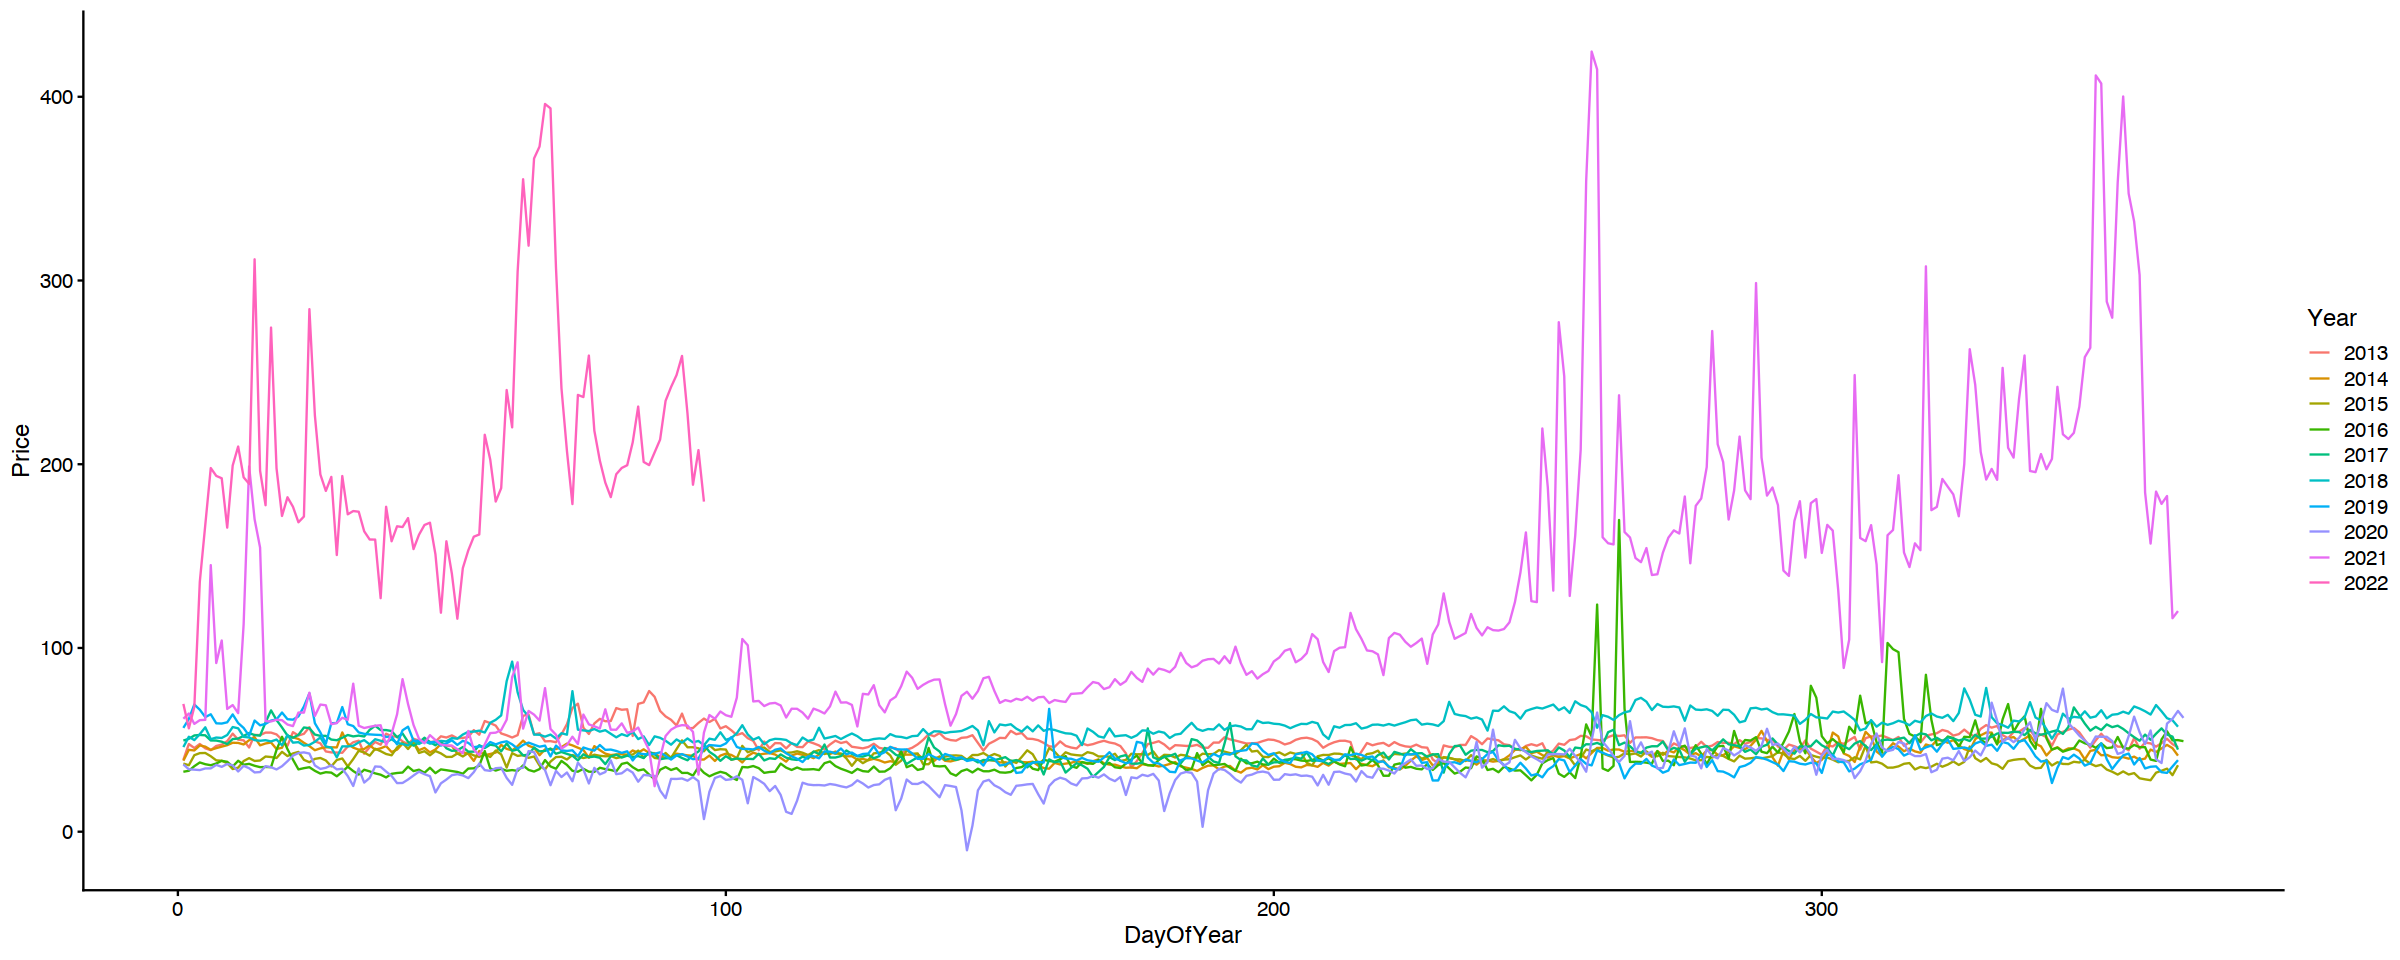

In [3]:
library(ggplot2)
library(cowplot)

options(repr.plot.width=20, repr.plot.height=8)

ggplot() + geom_line(data = df, aes(x = DayOfYear, y = Price, color = Year)) + theme_half_open()

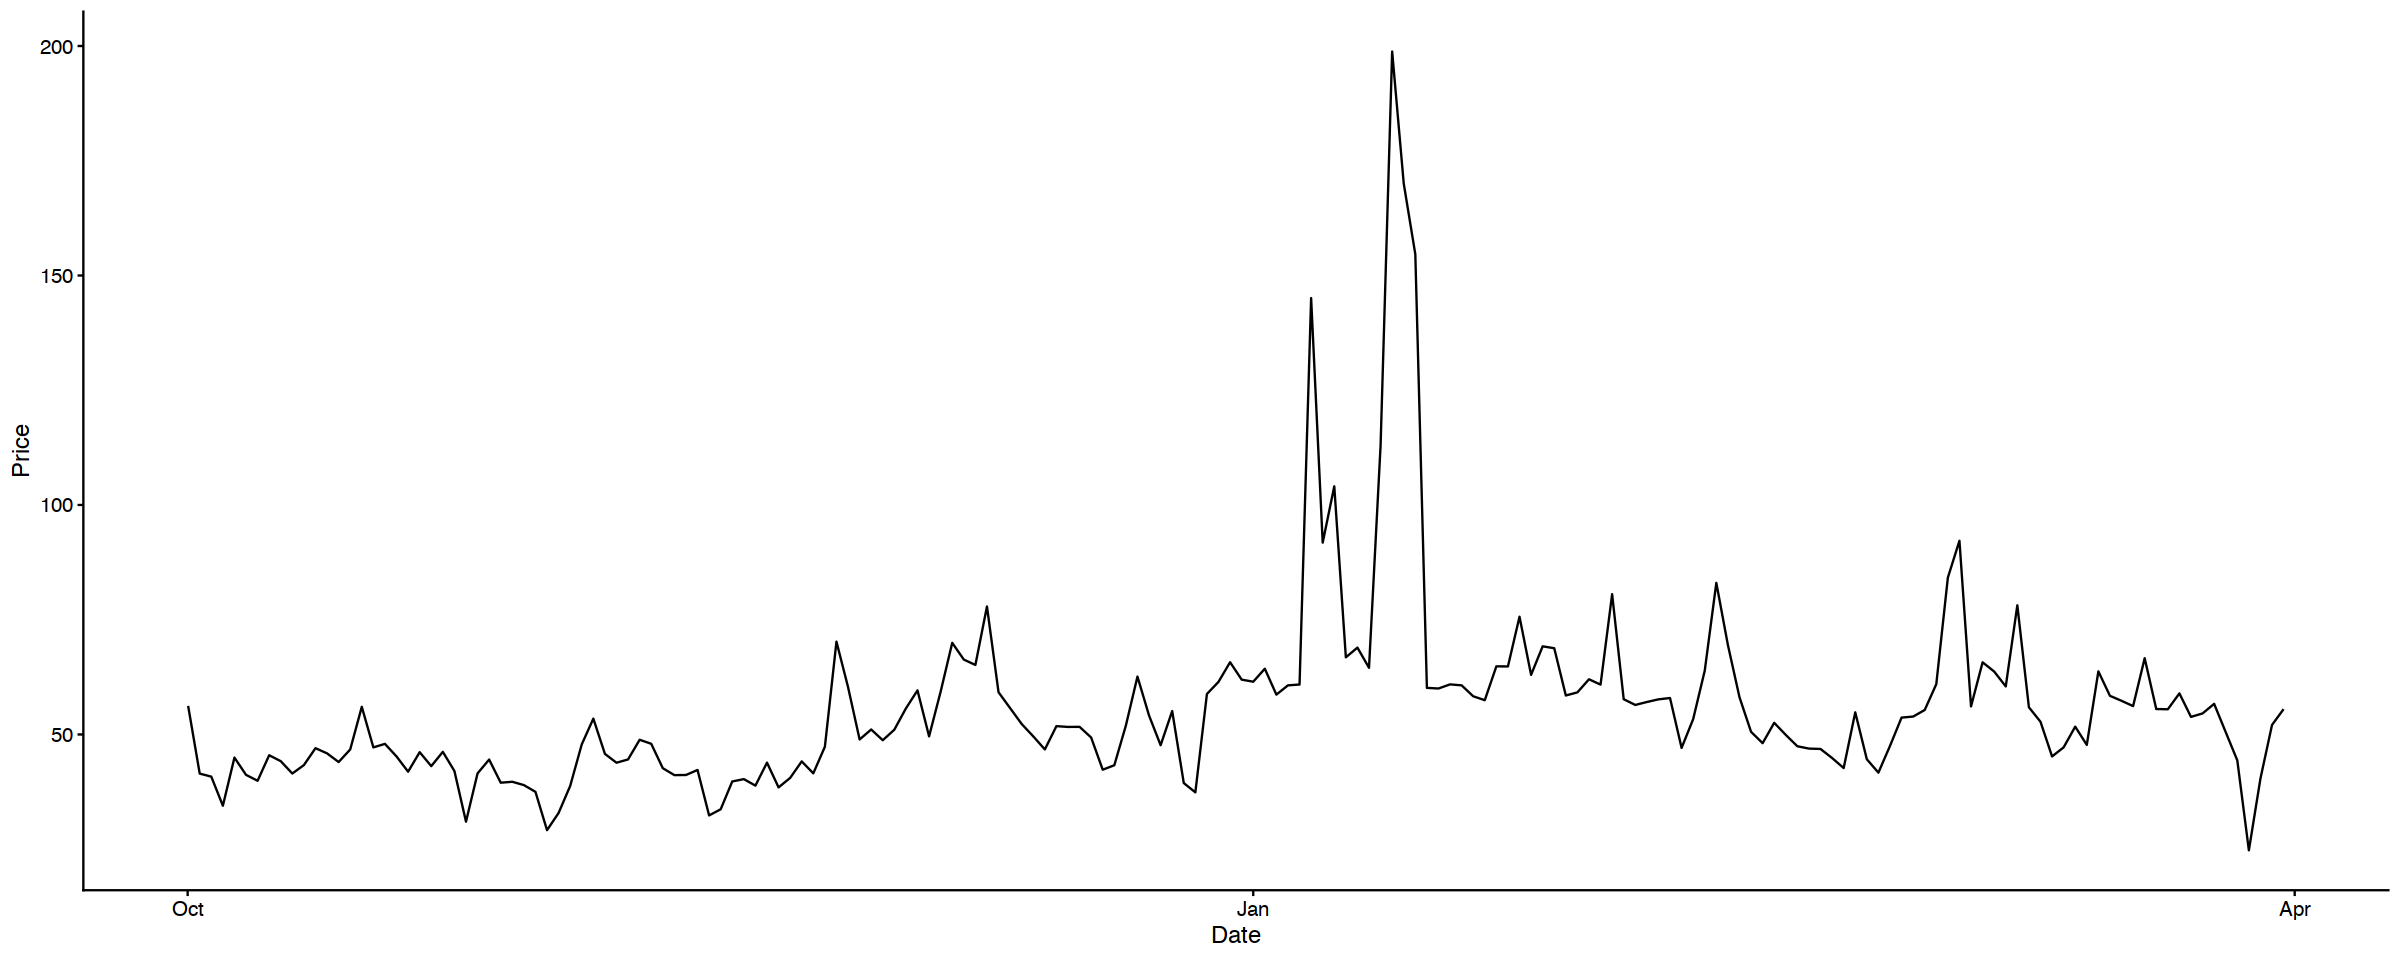

In [4]:
# Winter 2020

winter_2020 <- df[which((df$Year == '2020' & df$Month >= 10 ) | (df$Year == '2021' & df$Month <= 3 )), ]

winter_2020 <- mutate(winter_2020, LogPrice = log(Price))

plot <- ggplot() + geom_line(data = winter_2020,
                     aes(x = Date, y = Price)) + theme_half_open()

plot

tmpfile <- tempfile("obs_traj",
                    tmpdir = "/Users/jake/Documents/temp/dissertation/report/images/fitting/full_model",
                    fileext = ".pdf")
save_plot(tmpfile, plot, base_height=8, base_width=12)

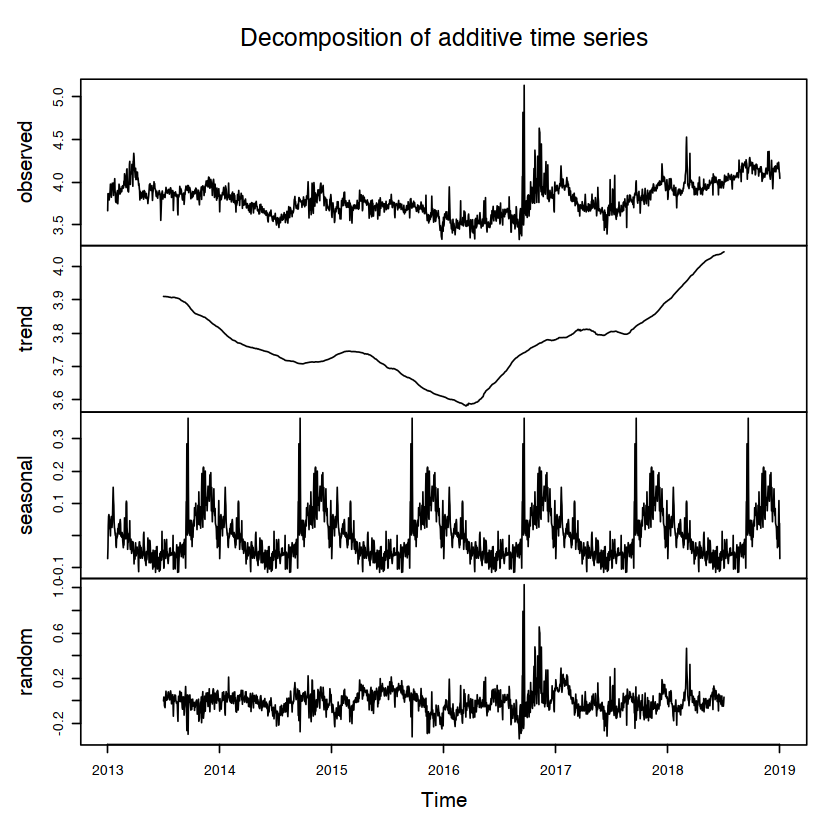

In [36]:
# remove seasonality

s <- ts(log(df[df['Year'] < 2019,'Price']), frequency=365, start <- c(2013, 1))

plot(decompose(s))

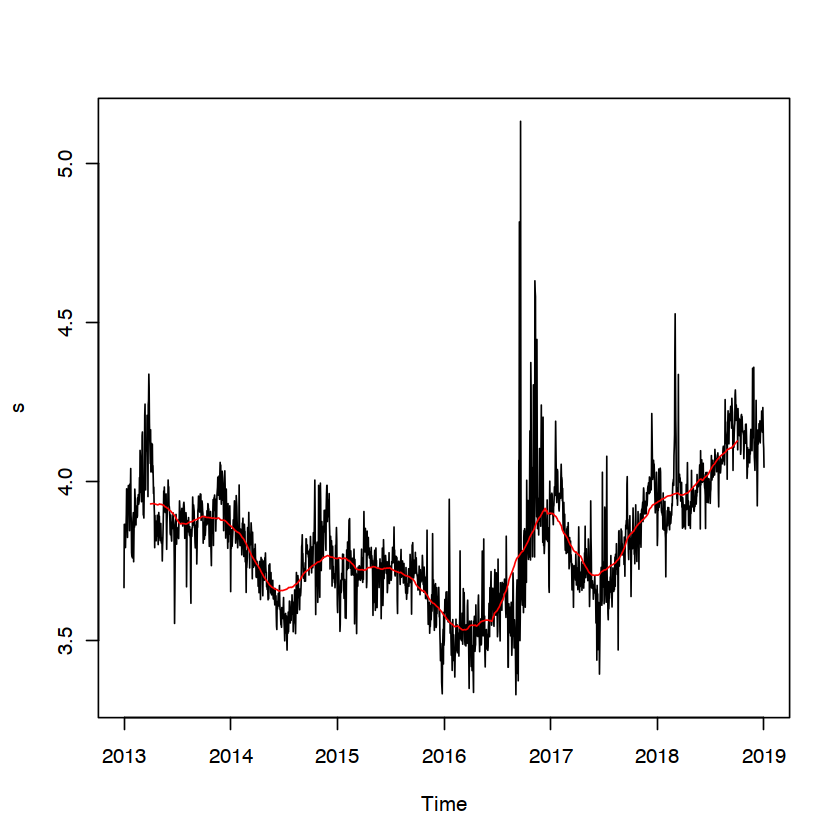

In [37]:
library(forecast)

plot(s)

avg <- ma(s, order=floor(365/2))

lines(avg, col='Red')

Warning message in `-.default`(s[!is.na(avg)], avg):
“longer object length is not a multiple of shorter object length”


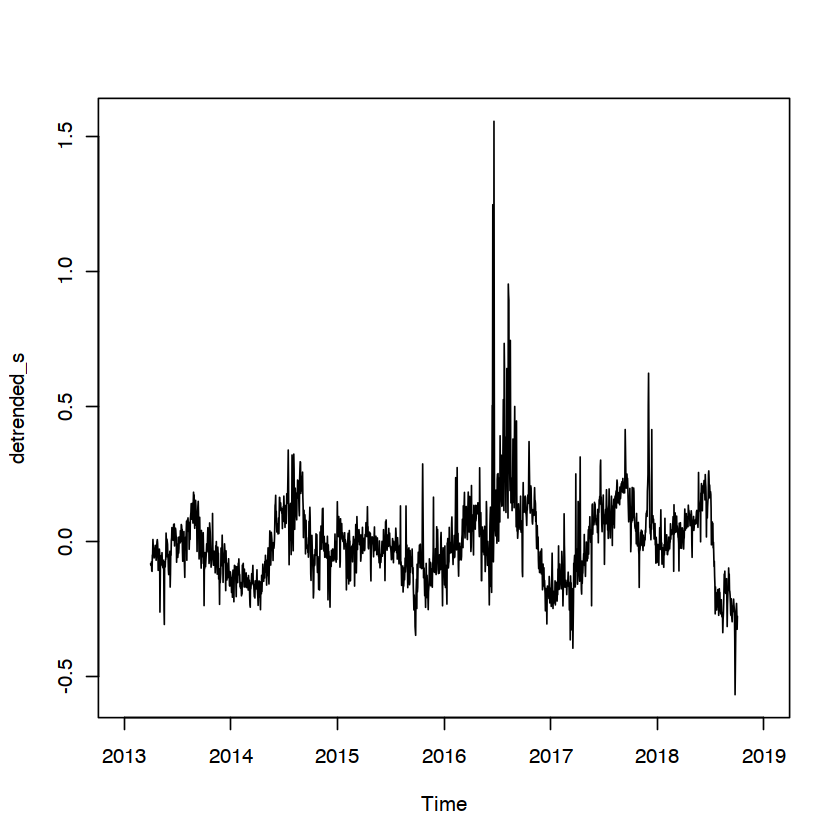

In [47]:
detrended_s <- s[!is.na(avg)] - avg

plot(detrended_s)

In [48]:
weekdays(df[df['Year'] < 2019,][!is.na(avg),'Date'][1])

[1] "Tuesday"

In [5]:
#obs <- as.vector(detrended_s[7:length(detrended_s)])
#obs <- obs[!is.na(obs)]
obs <- winter_2020$LogPrice
obs_length <- length(obs)

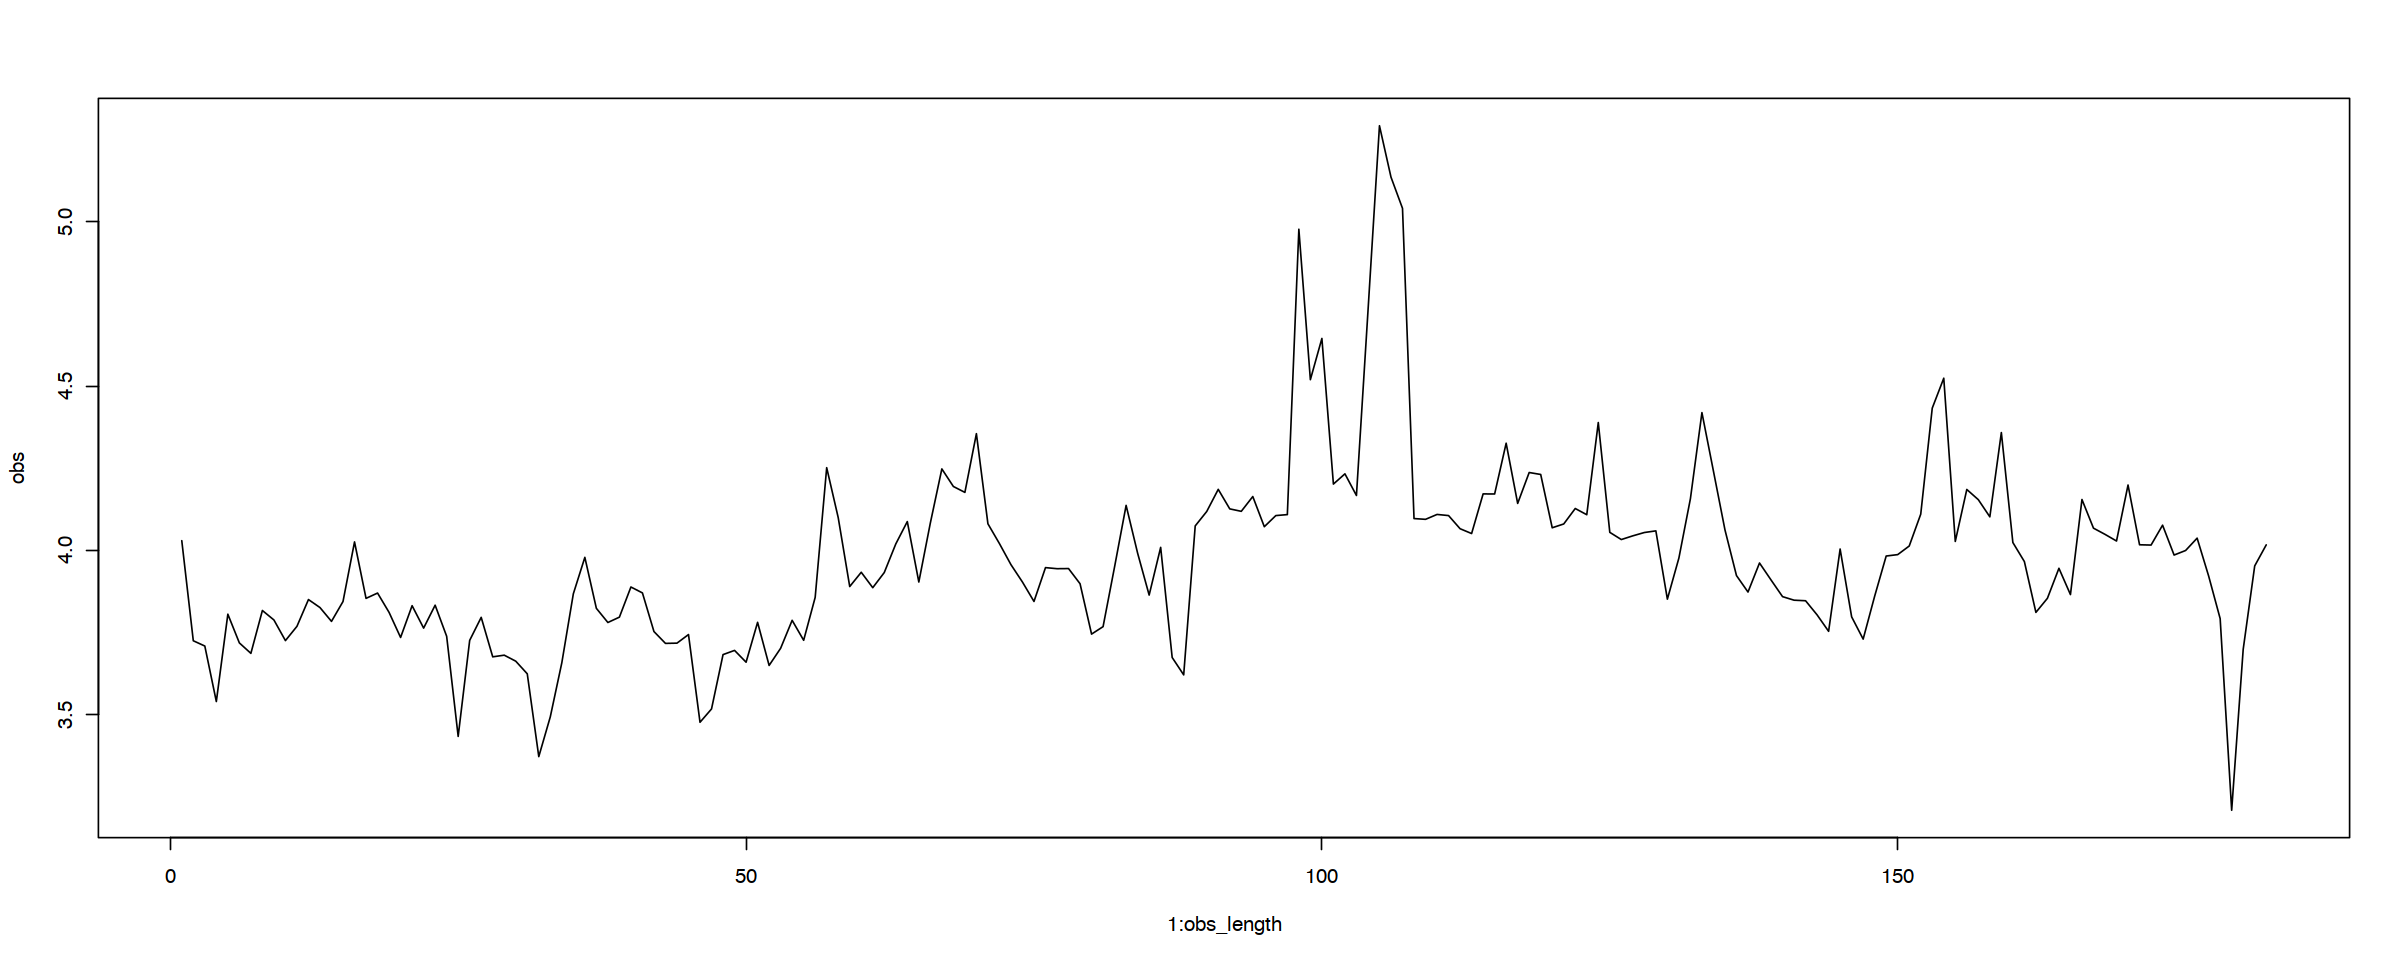

In [6]:
options(repr.plot.width=20, repr.plot.height=8)
plot(1:obs_length, obs, 'l')

In [7]:
obs_ord_poly <- cbind(rep(1, obs_length-1),
                     poly(ordered_differences(obs), 3))

stats <- function(xs) {
  sat <- extract_days(xs, 5)
  sun <- extract_days(xs, 6)
  
  mu <- mean(xs)
  sigma <- sd(xs)
  
  med <- median(xs)
  
  # autoregression
  
  X <- cbind(rep(1, obs_length - 3),
             xs[1:(obs_length-3)],
             xs[2:(obs_length-2)],
             xs[3:(obs_length-1)])
  
  reg <- lm.fit(X, xs[4:obs_length])$coefficients
  
  gam <- gamma(exp(xs), TRUE)
  
  #shape <- lm.fit(obs_od_poly, ordered_differences(xs))$coefficients
  
  shape <- lm.fit(obs_ord_poly, ordered_differences(xs))$coefficients
  
  #spike_series_xs <- spike_series(xs)
  #spike_reg <- lm.fit(spike_series_obs_ord,
  #                    spike_series_xs[order(spike_series_xs)])$coefficients
  
  #dif_reg <- lm.fit(obs_ord_diff, ordered_differences(xs))$coefficients
  #spike <- length(spike_detection(xs, 0.45))
  
  ttr <- times_to_revert(xs)
  
  diffs <- diff(xs)
  
  # dropping: kurt, sd
  
  return(c(mu, mean(sat) - mu, mean(sun) - mu, reg[2],
           skewness(xs), reg[4], IQR(xs), max(abs(diffs)),
           max(abs(xs)), spike_test(xs, 2), shape))    
}

In [8]:
synthetic_likelihood <- function(pars, N, obs_length, s_obs) {
  stats_matrix <- matrix(0, nrow=N, ncol=length(s_obs))
  
  for (i in 1:N) {
    sim <- do.call(regime_jump_model, as.list(append(pars, obs_length)))
    stats_matrix[i, ] = stats(sim)
  }
  
  mu <- colMeans(stats_matrix)
  Sigma <- cov(stats_matrix)
  
  out <- dmvn(s_obs, mu, Sigma, log = TRUE)
  
  return(out)
}

s_obs <- stats(obs)
print(s_obs)

N=100

likfun <- function(params) {
  return(synthetic_likelihood(params, N, obs_length, s_obs))
}

                                                     x2               
 3.974358e+00  2.130511e-02  9.529947e-02 -1.636728e-02  1.413803e+00 
           x4                                                         
 7.550639e-01  3.052364e-01  9.441291e-01  5.292249e+00  9.000000e+00 
                          1             2             3 
-7.020501e-05  2.605495e+00  5.426212e-16 -9.959900e-16 


In [9]:
init_par <- c(mean(obs),
              -mean(obs) + mean(extract_days(obs, c(5))),
              -mean(obs) + mean(extract_days(obs, c(6))),
              log(0.1 / (1 - 0.1)),
              log(0.05),
              log(0.5),
              log(0.5),
              log(0.2 / (1 - 0.2)),
              log(0.5),
              log(0.995 / (1 - 0.995)))

res <- synlik:::ml(likFun = likfun,
                   initPar = init_par,
                   initCov = diag(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1))^2,
                   np = 50,
                   niter = 100)

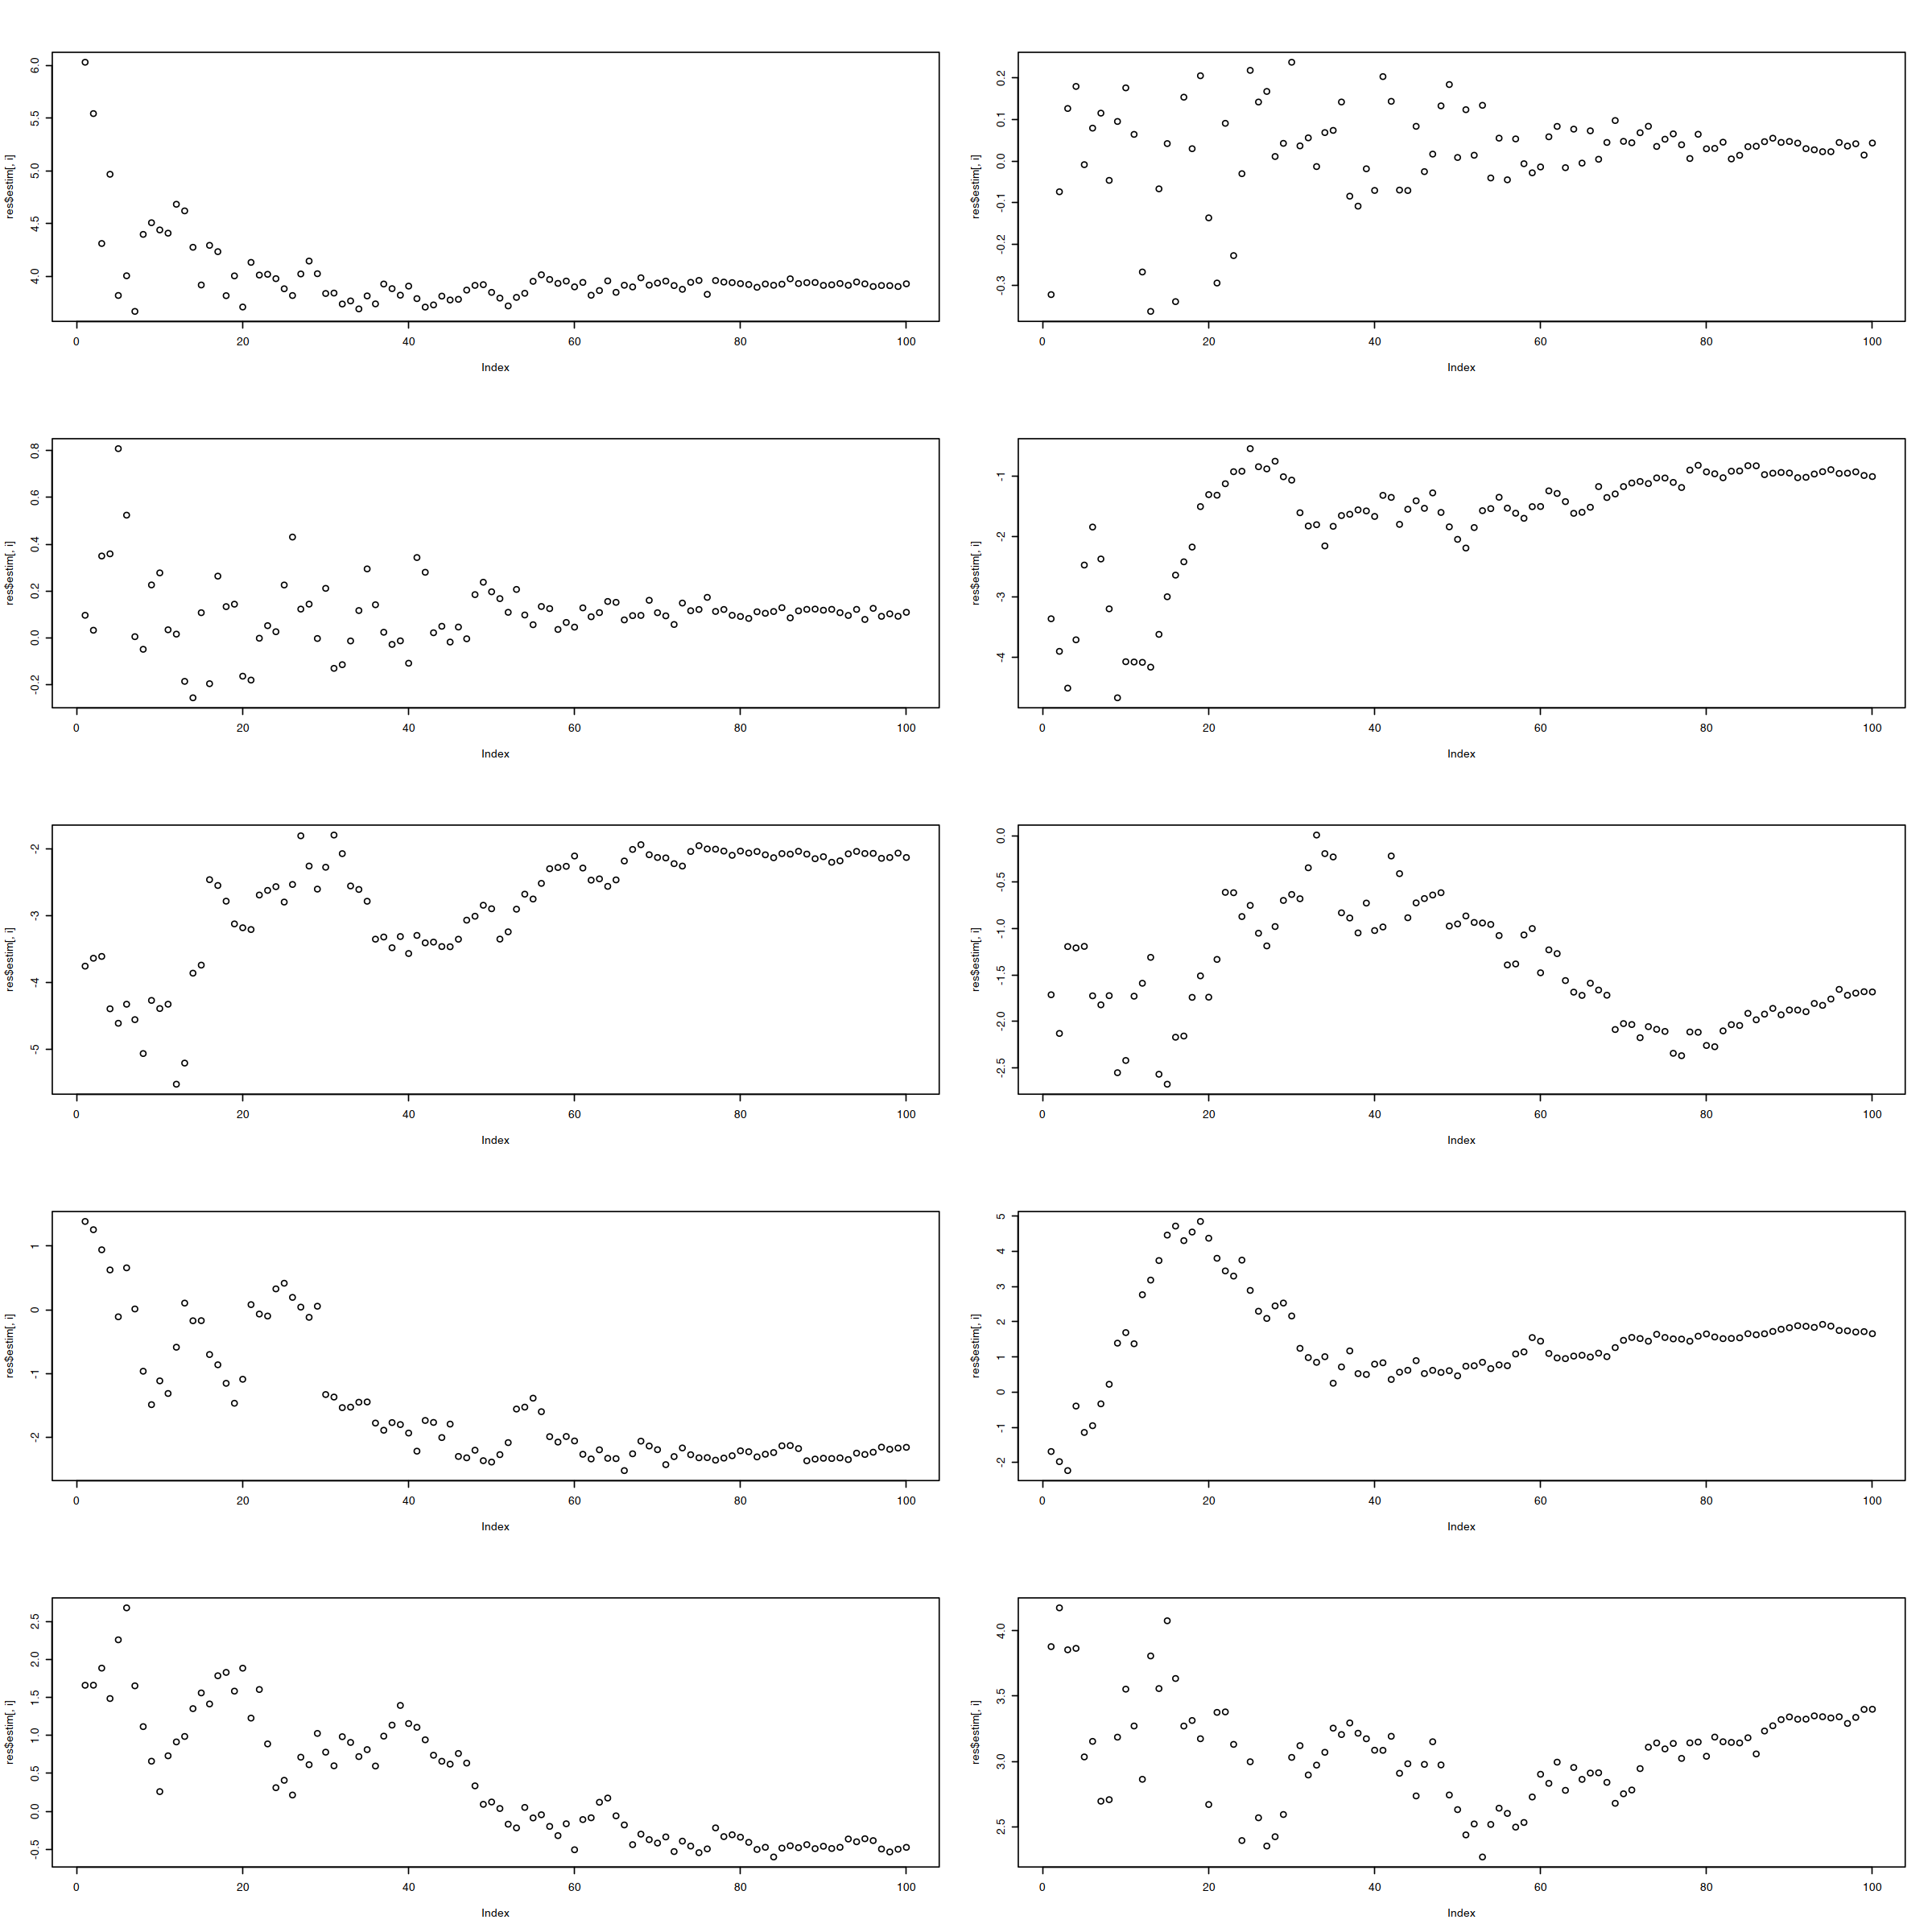

In [10]:
options(repr.plot.width=20, repr.plot.height=20)
par(mfrow = c(5, 2))
for (i in 1:10) {
  plot(res$estim[, i])
}

In [11]:
sample_trajectories = data.frame(x = 1:obs_length,
                                 "Observed Trajectory" = obs,
                                 "Sample Trajectory 1" = do.call(regime_jump_model, as.list(append(res$estim[100, ], obs_length))),
                                 "Sample Trajectory 2" = do.call(regime_jump_model, as.list(append(res$estim[100, ], obs_length))),
                                 "Sample Trajectory 3" = do.call(regime_jump_model, as.list(append(res$estim[100, ], obs_length))),
                                 "Sample Trajectory 4" = do.call(regime_jump_model, as.list(append(res$estim[100, ], obs_length))),
                                 "Sample Trajectory 5" = do.call(regime_jump_model, as.list(append(res$estim[100, ], obs_length))),
                                check.names = FALSE) 

m <- melt(sample_trajectories, id.vars="x")

plot <- ggplot(m, aes(x,value)) + 
    geom_line() + 
    facet_wrap(~variable) +
    theme_half_open() +
    ylab('Log Price') +
    xlab('Day')

tmpfile <- tempfile("sim_traj",
                    tmpdir = "/Users/jake/Documents/temp/dissertation/report/images/fitting/full_model",
                    fileext = ".pdf")
save_plot(tmpfile, plot, base_height=8, base_width=12)

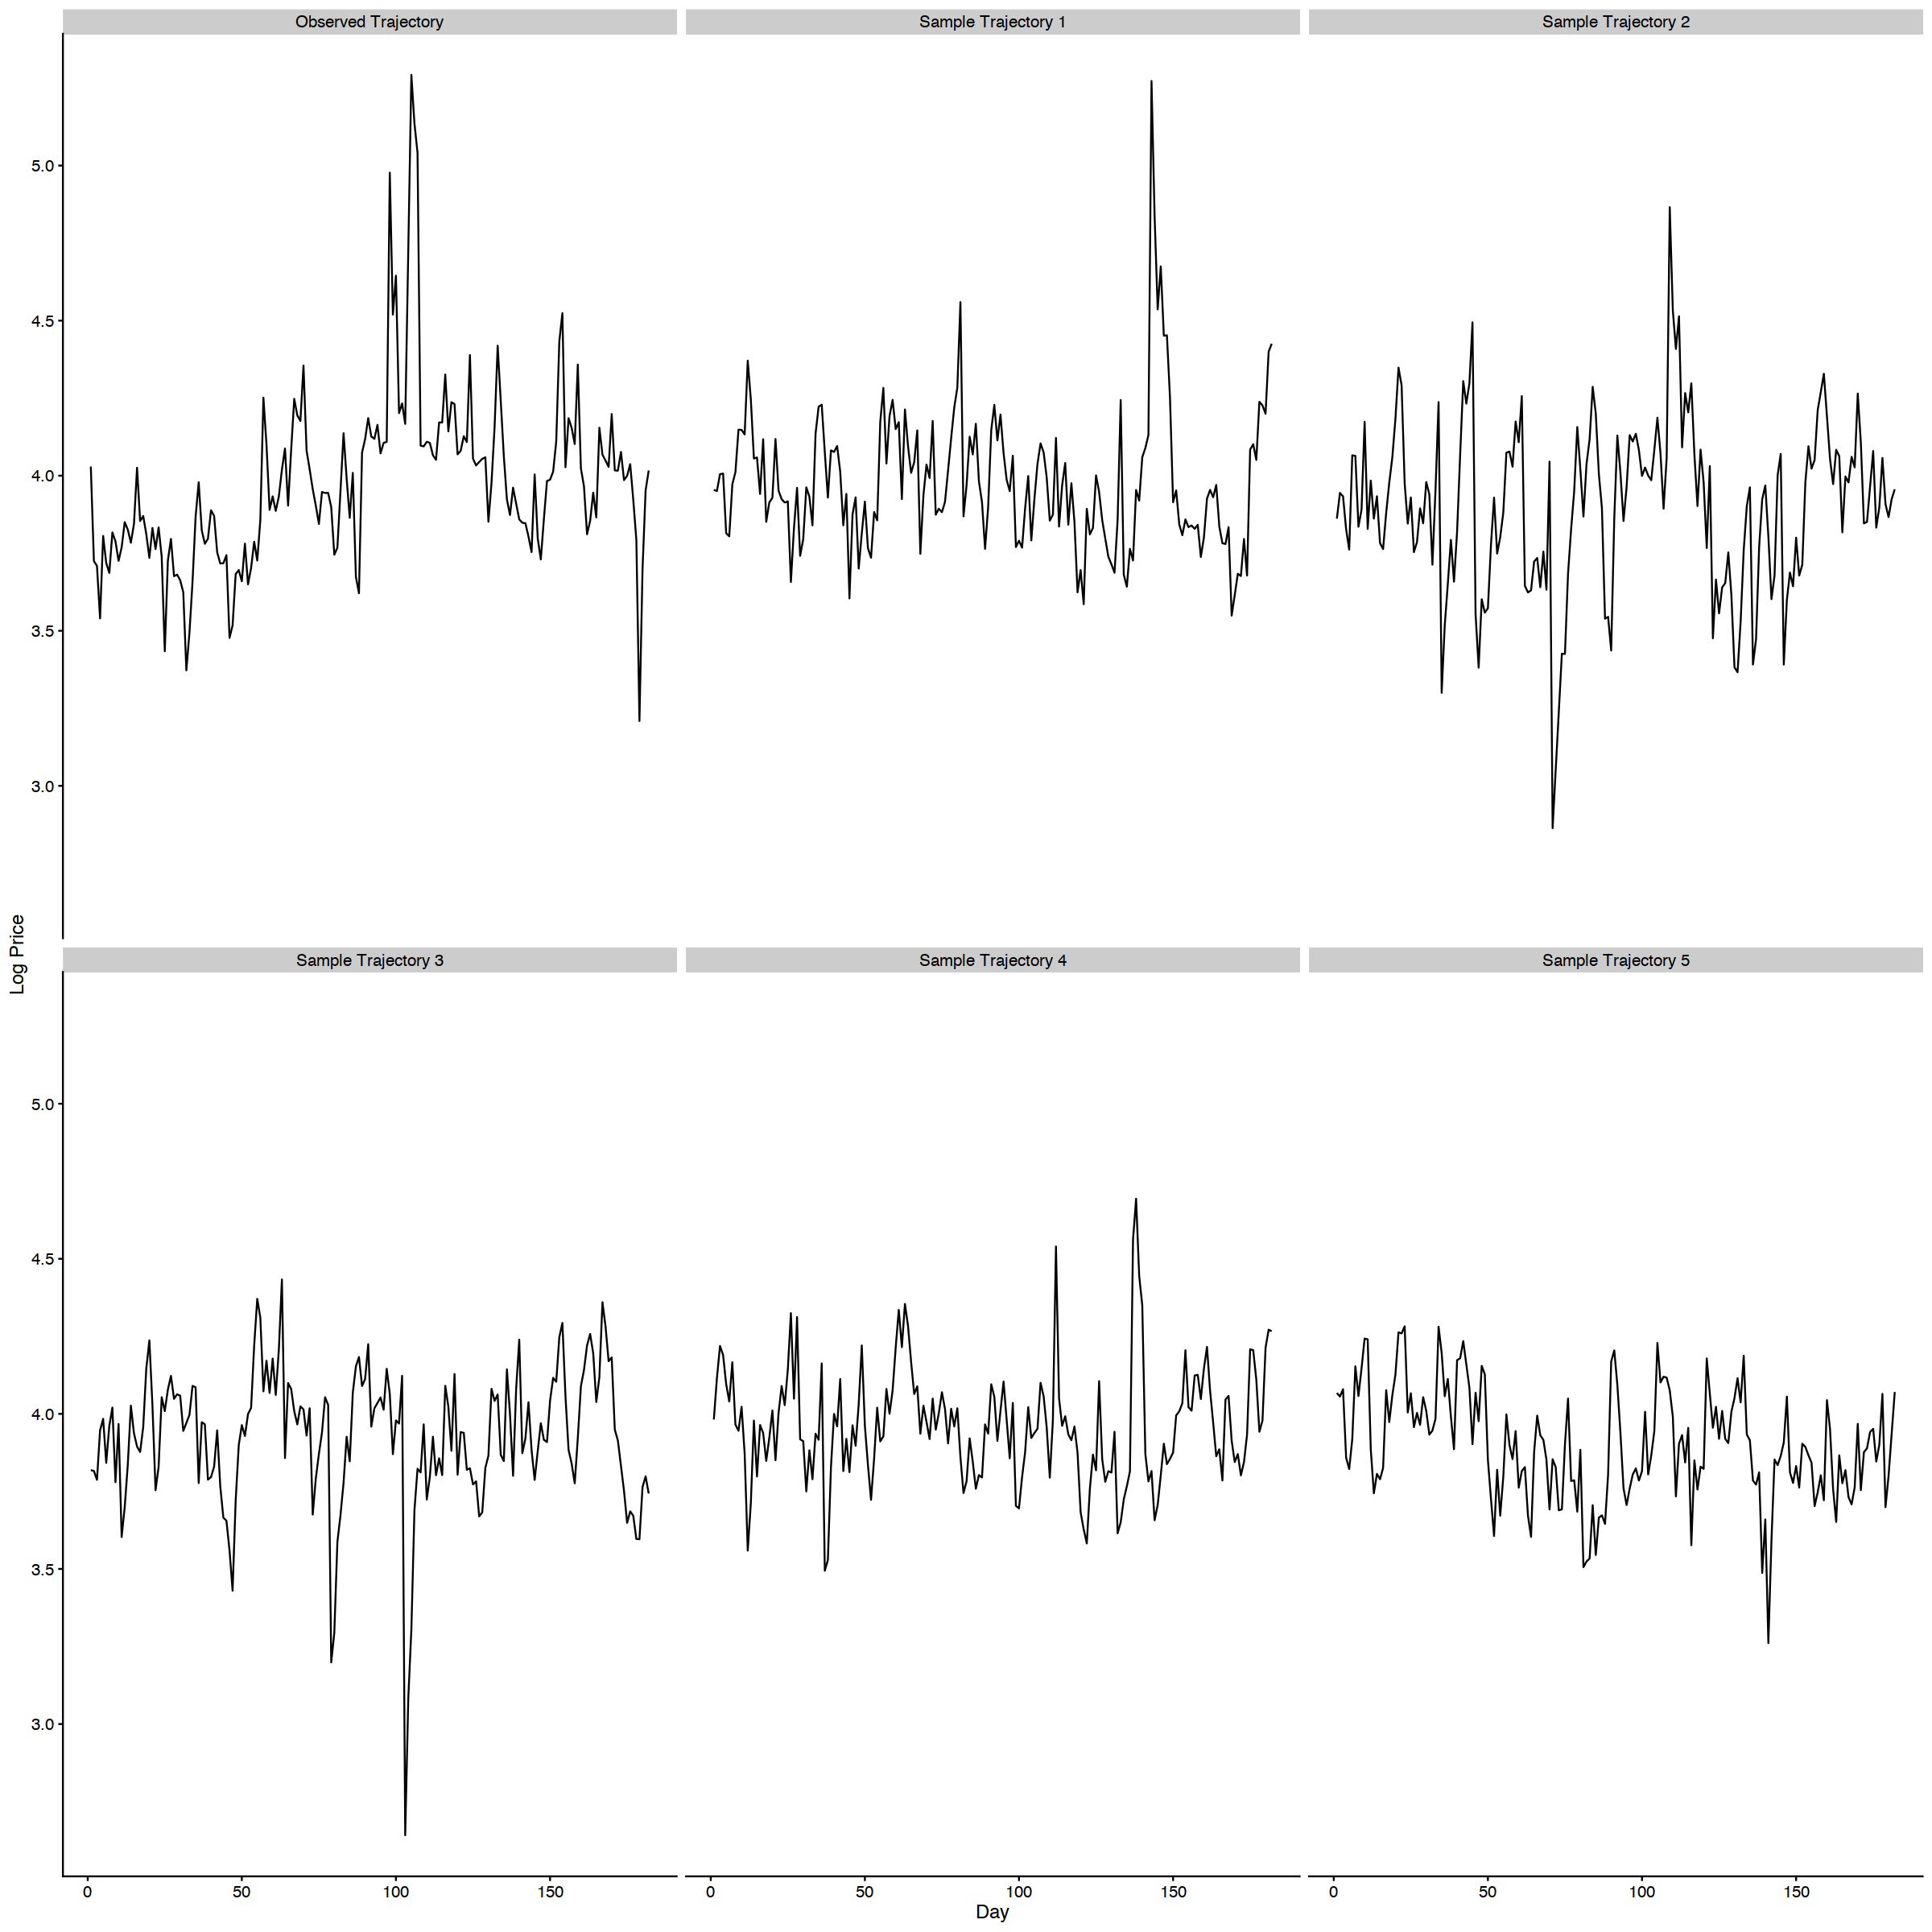

In [12]:
plot

In [28]:
init_par

[1]  3.97435761  0.02130511  0.09529947 -2.19722458 -2.99573227 -0.69314718
 [7] -0.69314718 -1.38629436 -0.69314718  5.29330482

In [27]:
res$estim[100, ]

[1]  3.92993386  0.04344592  0.10927941 -1.00940052 -2.13129143 -1.68214322
 [7] -2.15194746  1.65798398 -0.47443673  3.39869389

In [174]:
obs_length

[1] 182

In [14]:
rjm_track <- function(mu_0, beta_1, beta_2, alpha_0, sigma_0,
                              mu_1, sigma_1, alpha_neg_1, sigma_neg_1,
                              p, t_max) {
  
  # transform all constrained parameters
  mu_1 <- exp(mu_1)
  sigma_0 <- exp(sigma_0)
  sigma_1 <- exp(sigma_1)
  sigma_neg_1 <- exp(sigma_neg_1)
  alpha_0 <- exp(alpha_0) / (1 + exp(alpha_0))
  alpha_neg_1 <- exp(alpha_neg_1) / (1 + exp(alpha_neg_1))
  p <- exp(p) / (1 + exp(p))
  ys <- rep(NA, t_max)

  epsilons <- rnorm(t_max)

  # pre-calculate samples for efficiency
  enter_spike_samples <- sample(c(0, 1),
                                size = t_max,
                                replace = TRUE,
                                prob = c(p, 1 - p))
  
    spikes <- c()
    
  regime <- 0
  x <- 0

  for (t in 1:t_max) {
    # deterministic part
    f <- mu_0
    day <- (t - 1) %% 7

    if (day == 5) {
      # Saturday
      f <- f + beta_1
    } else if (day == 6) {
      # Sunday
      f <- f + beta_2
    }

    # stochastic part (select regime based on last regime, then calculate dx)
    dx <- 0
    if (regime == 0) {
      regime <- enter_spike_samples[t]
    } else if (regime == 1) {
      regime <- -1
    } else if (regime == -1) {
      regime <- 0
    }

    if (regime == 0) {
      dx <- (-alpha_0 * x) + (sigma_0 * epsilons[t])
    } else if (regime == 1) {
        spikes <- c(spikes, t)
      dx <- mu_1 + (sigma_1 * epsilons[t])
    } else if (regime == -1) {
      dx <- (-alpha_neg_1 * x) + (sigma_neg_1 * epsilons[t])
    }

    x <- x + dx

    ys[t] <- f + x
  }

  return(list(ys = ys, spikes = spikes))
}

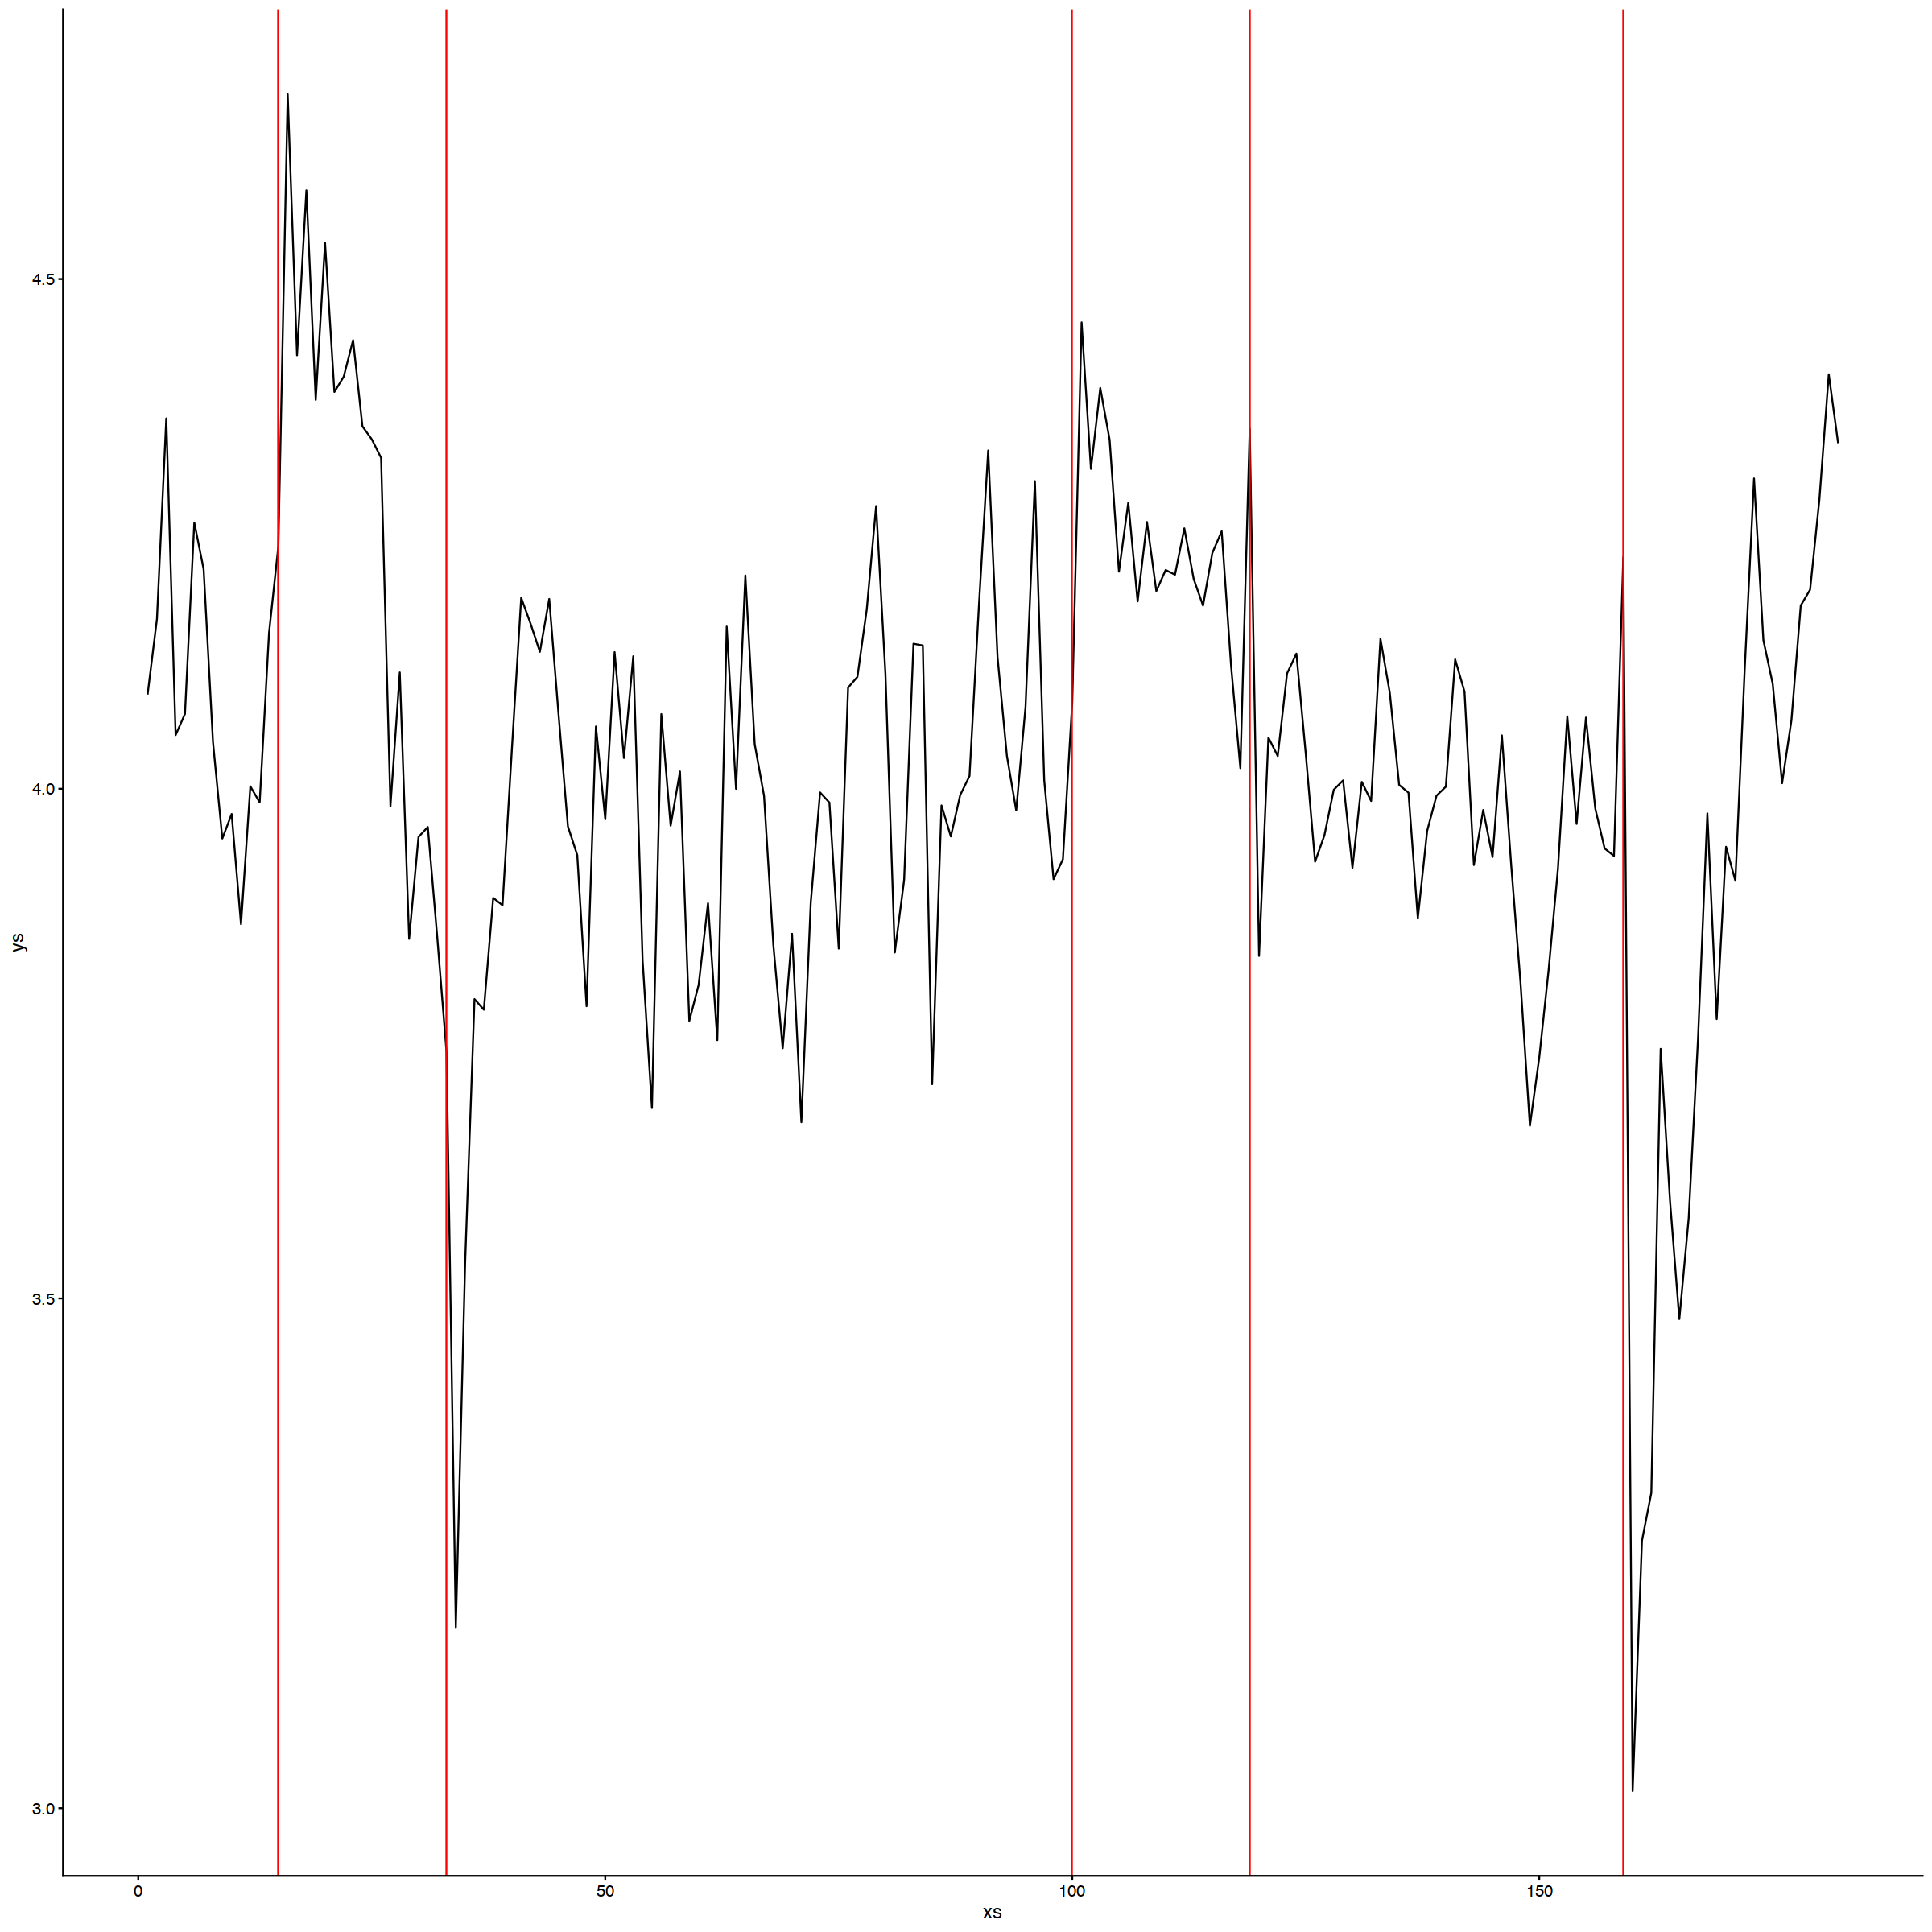

In [26]:
sim = do.call(rjm_track, as.list(append(res$estim[100, ], obs_length)))

#plot(1:obs_length, sim$ys, 'l')

#for (spike in sim$spikes) {
#    abline(v=spike, col='Red')
#}

plot <- ggplot(data.frame(xs=1:obs_length,
                  ys=sim$ys), aes(x=xs, y=ys)) +
    geom_line() +
    theme_half_open() +
    geom_vline(xintercept = sim$spikes, col='Red')

plot

tmpfile <- tempfile("neg_spikes",
                    tmpdir = "/Users/jake/Documents/temp/dissertation/report/images/fitting/full_model",
                    fileext = ".pdf")
save_plot(tmpfile, plot, base_height=8, base_width=12)

In [30]:
plot2 <- plot + ylab('Log Price') + xlab('Day')

tmpfile <- tempfile("neg_spikes",
                    tmpdir = "/Users/jake/Documents/temp/dissertation/report/images/fitting/full_model",
                    fileext = ".pdf")
save_plot(tmpfile, plot2, base_height=8, base_width=12)